In [1]:
#Basic setups 
import numpy as np
from skimage import io
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from dataloader import load_data
from PCA import PCA

#Load and preprocess the data
#We change the load_data function by deleting the value assigned to datatype in the definition
aligned_data,cnt = load_data("./aligned/")

Car types: ['Convertible', 'Minivan', 'Pickup', 'Sedan'] 

Convertible: 149 # of images
Minivan: 148 # of images
Pickup: 150 # of images
Sedan: 150 # of images


In [3]:

from random import shuffle
import math
def kFold(K,data):
    """This function is used to implement k-fold cross-validation"""
    #Shuffle the dataset to get more accurate performance
    index = np.arange(0,len(data))
    shuffled_idx = np.random.shuffle(index)
    shuffled_data_temp = data[shuffled_idx]
    shuffled_data = shuffled_data_temp[0,:,:]
    
    print("original shape:",data.shape)
    print("shuffled shape:",shuffled_data.shape)
    
    #Split the data into training, testing and handout set
    size = len(data)
    set_size = math.floor(size/K)
    index_train = int(set_size*(K-2))
    index_test = int(set_size*(K-1))

    
    training_set = shuffled_data[:index_train]
    testing_set = shuffled_data[index_train:index_test]
    val_set = shuffled_data[index_test:]
    print("trainshape:",training_set.shape)
    return training_set,testing_set,val_set



In [4]:
def dataSplit(K,data):
    """This function is used to implement k-fold cross-validation"""
    #Shuffle the dataset to get more accurate performance
    index = np.arange(0,len(data))
    shuffled_idx = np.random.shuffle(index)
    shuffled_data = data[shuffled_idx]
    
    #Split the data into training, testing and handout set
    size = len(data)
    set_size = math.floor(size/K)
    folds = []
    for i in range(K-1):
        temp = data[i*set_size:(i+1)*set_size,:]
        folds.append(temp)
    folds.append(data[K*set_size:,:])
    return folds

In [5]:
def img_flatten(img):
    """This function is used to convert 2-D images to 1-D vectors"""
    flatten_img = []
    for i in range(len(img)):
        flatten_img.append(img[i].flatten())
    return np.array(flatten_img)

In [6]:
def plot_top_PCs(eigenvectors,n):
    imgs = []
    plt.figure()
    for i in range(n):
        eigen = egenvectors[i]
        image = np.reshape(eigen,(200,300))
        image = Image.fromarray(image)
        imgs.append(img)
        plt.subplot(1,n,i)
        plt.imshow(imgs[i])

In [185]:
def projectPC(x,mean_image, top_sqrt_eigen_values, top_eigen_vectors):
    """This function is used to project the data x on the given training set x_train"""
    
    msd = x - mean_image
    projected_image = np.matmul(msd,top_eigen_vectors)/top_sqrt_eigen_values
    projected = np.insert(projected_image,0,1,axis=1)
    return projected

In [186]:
#Load data 
resized_data,resize_cnt = load_data("./resized/")

num_PC = 14
minivan_resize = resized_data.get('Minivan')
convertible_resize = resized_data.get('Convertible')

minivan_resize_flatten = img_flatten(minivan_resize)
convertible_resize_flatten = img_flatten(convertible_resize)

num_fold = 10
trainM_resize,testM_resize,valM_resize = kFold(num_fold,minivan_resize_flatten)
trainC_resize,testC_resize,valC_resize = kFold(num_fold,convertible_resize_flatten)

print("trainM_resize shape:",trainM_resize.shape)

Car types: ['Convertible', 'Minivan'] 

Convertible: 150 # of images
Minivan: 150 # of images
original shape: (150, 60000)
shuffled shape: (150, 60000)
trainshape: (120, 60000)
original shape: (150, 60000)
shuffled shape: (150, 60000)
trainshape: (120, 60000)
trainM_resize shape: (120, 60000)


In [207]:
#Perform PCA to find top PCs on training set
#Minivan
projectedM_resize, mean_imageM_resize, top_sqrt_eigen_valuesM_resize, top_eigen_vectorsM_resize = PCA(trainM_resize,num_PC)
#Convertible
projectedC_resize, mean_imageC_resize, top_sqrt_eigen_valuesC_resize, top_eigen_vectorsC_resize = PCA(trainC_resize,num_PC)


#Project handout data on top PCs
projectedM_val = projectPC(valM_resize,mean_imageM_resize, top_sqrt_eigen_valuesM_resize, top_eigen_vectorsM_resize)
projectedC_val = projectPC(valC_resize,mean_imageC_resize, top_sqrt_eigen_valuesC_resize, top_eigen_vectorsC_resize)

#Project testing data on top n PCs
projectedM_test = projectPC(testM_resize,mean_imageM_resize, top_sqrt_eigen_valuesM_resize, top_eigen_vectorsM_resize)
projectedC_test = projectPC(testC_resize,mean_imageC_resize, top_sqrt_eigen_valuesC_resize, top_eigen_vectorsC_resize)

#Initialize training,val and testing dataset
X_train = np.concatenate((projectedM_resize, projectedC_resize), axis=0)
X_train = np.insert(X_train,0,1,axis=1)
y_train = np.concatenate((np.zeros(projectedM_resize.shape[0]), np.ones(projectedC_resize.shape[0])), axis=0)
y_train = y_train.reshape(y_train.shape[0],1)

X_hold = np.concatenate((projectedM_val, projectedC_val), axis=0)
y_hold = np.concatenate((np.zeros(projectedM_val.shape[0]), np.ones(projectedC_val.shape[0])), axis=0)
y_hold = y_hold.reshape(y_hold.shape[0],1)

X_test = np.concatenate((projectedM_test, projectedC_test), axis=0)
y_test = np.concatenate((np.zeros(projectedM_test.shape[0]), np.ones(projectedC_test.shape[0])), axis=0)
y_test = y_test.reshape(y_test.shape[0],1)

print("shape of x_train,x_test and x_hold are",X_train.shape,X_test.shape,X_hold.shape)
print("shape of y_train,y_test and y_hold are",y_train.shape,y_test.shape,y_hold.shape)

shape of x_train,x_test and x_hold are (240, 15) (30, 15) (30, 15)
shape of y_train,y_test and y_hold are (240, 1) (30, 1) (30, 1)


In [208]:

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def weight_matrix(x):
    weight =  np.zeros(len(x[0]))
    return weight


def accuracy(x,y,weight):
    x = np.asmatrix(x)
    y = np.asmatrix(y)
    weight = np.asmatrix(weight)
    correct = 0
    y_hat = sigmoid(x*weight.T)
    
    for i in range(len(y_hat)):
        
        if (y_hat[i] >=0.5 and y[i] == 1) or (y_hat[i]<0.5 and y[i] == 0):
            correct += 1
    return correct / len(y_hat)
    
def cross_entropy(x,y,weight):
    x = np.asmatrix(x)
    y = np.asmatrix(y)
    weight = np.asmatrix(weight)
    
    y_hat = sigmoid(x*weight.T)
    cost = np.multiply(-y,np.log(y_hat))-np.multiply((1-y),np.log(1-y_hat))
    cost = np.sum(cost)/len(x)
    return cost

def gradientDescent(x,y,weight,learning_rate):
    x = np.asmatrix(x)
    y = np.asmatrix(y)
    weight = np.asmatrix(weight)
    
    error = sigmoid(x*weight.T)-y
    
    gradient = x.T*error/len(x)
    gradient = np.squeeze(np.asarray(gradient))
    weight_updated = weight-learning_rate*gradient
    weight_updated  = np.squeeze(np.asarray(weight_updated))
    print("weight updated",weight_updated,"gradient",gradient)
    return gradient,weight_updated
    

In [209]:
max_iter = 300
learning_rate = 10

train_error = np.zeros((max_iter,1))
hold_out_error = np.zeros((max_iter,1))
test_error = np.zeros((max_iter,1))
            
train_acc = np.zeros((max_iter,1))
hold_out_acc=np.zeros((max_iter,1))
test_acc = np.zeros((max_iter,1))

weight = weight_matrix(X_train)
for i in range(max_iter):
    grad,weight = gradientDescent(X_train,y_train,weight,learning_rate)
    
    train_error[i] = cross_entropy(X_train,y_train,weight)
    
    train_acc[i] = accuracy(X_train,y_train,weight)
                                                 
    #Calculate the error for hold out set using updated weight
    hold_out_error[i] = cross_entropy(X_hold,y_hold,weight)
    hold_out_acc[i] = accuracy(X_hold,y_hold,weight)
                                                 
                
    #Calculate the error for test set using updated weight
    test_error[i] = cross_entropy(X_test,y_test,weight)
    test_acc[i] = accuracy(X_test,y_test,weight)

    print("i th iteration:",train_acc[i],hold_out_acc[i],test_acc[i])

weight updated [ 0.00000000e+00 -1.86482774e-17 -1.04083409e-17  1.46005893e-17
 -2.68882139e-17  1.64798730e-17 -1.98047597e-17  8.09537622e-18
  2.25514052e-17 -1.27213055e-17  1.03360607e-17  1.44560290e-17
 -1.04083409e-17  2.12503626e-17  3.03576608e-18] gradient [ 0.00000000e+00  1.86482774e-18  1.04083409e-18 -1.46005893e-18
  2.68882139e-18 -1.64798730e-18  1.98047597e-18 -8.09537622e-19
 -2.25514052e-18  1.27213055e-18 -1.03360607e-18 -1.44560290e-18
  1.04083409e-18 -2.12503626e-18 -3.03576608e-19]
i th iteration: [0.5] [0.5] [0.5]
weight updated [ 0.00000000e+00 -3.72965547e-17 -2.08166817e-17  2.92011785e-17
 -5.37764278e-17  3.29597460e-17 -3.96095194e-17  1.61907524e-17
  4.51028104e-17 -2.54426110e-17  2.06721214e-17  2.89120579e-17
 -2.08166817e-17  4.25007252e-17  6.07153217e-18] gradient [ 0.00000000e+00  1.86482774e-18  1.04083409e-18 -1.46005893e-18
  2.68882139e-18 -1.64798730e-18  1.98047597e-18 -8.09537622e-19
 -2.25514052e-18  1.27213055e-18 -1.03360607e-18 -1.4

i th iteration: [0.5] [0.46666667] [0.5]
weight updated [-4.62592927e-17 -6.34791158e-16 -2.45707763e-16  4.11155545e-16
 -9.75473407e-16  5.58251107e-16 -5.42233667e-16  2.06397894e-16
  7.05323480e-16 -5.36128827e-16  2.69524368e-16  2.77564754e-16
 -3.22488240e-16  6.97387940e-16  1.43551080e-16] gradient [ 0.00000000e+00  9.39641883e-19  0.00000000e+00 -7.66169535e-19
  1.47451495e-18 -6.07153217e-19  1.51788304e-18  0.00000000e+00
 -9.83009970e-19  1.27213055e-18  1.22876246e-19  5.78241159e-20
  4.62592927e-19 -7.37257477e-19 -5.34873072e-19]
i th iteration: [0.49166667] [0.43333333] [0.5]
weight updated [-5.08852220e-17 -6.42065234e-16 -2.45674378e-16  4.18328344e-16
 -9.88192770e-16  5.64694422e-16 -5.55054966e-16  2.05989705e-16
  7.13579255e-16 -5.49669598e-16  2.67853867e-16  2.76293523e-16
 -3.26750191e-16  7.02248076e-16  1.48654329e-16] gradient [ 4.62592927e-19  7.27407522e-19 -3.33850291e-21 -7.17279849e-19
  1.27193628e-18 -6.44331572e-19  1.28212997e-18  4.08188782e-2

i th iteration: [0.5] [0.46666667] [0.56666667]
weight updated [-7.86407976e-17 -8.39318456e-16 -2.96047804e-16  6.52414598e-16
 -1.39409669e-15  7.60760106e-16 -8.81957656e-16  2.06703799e-16
  9.94055883e-16 -8.32047220e-16  2.79691461e-16  9.46200478e-17
 -4.50826857e-16  8.57480017e-16  1.47977879e-16] gradient [ 0.00000000e+00  7.70775609e-19  2.42413990e-19 -5.36579487e-19
  9.82815698e-19 -3.26298935e-19  1.03276347e-18 -1.70052376e-20
 -7.38640147e-20  9.66634992e-21  1.81506089e-19  7.05364240e-19
 -6.53097974e-20 -3.70365372e-19  4.29316942e-19]
i th iteration: [0.49583333] [0.46666667] [0.56666667]
weight updated [-7.86407976e-17 -8.47026212e-16 -2.99628426e-16  6.57780393e-16
 -1.40276837e-15  7.64023096e-16 -8.92285290e-16  2.06873851e-16
  9.94794523e-16 -8.32143883e-16  2.77876400e-16  8.75664054e-17
 -4.54799688e-16  8.60027188e-16  1.45997674e-16] gradient [ 0.00000000e+00  7.70775609e-19  3.58062221e-19 -5.36579487e-19
  8.67167466e-19 -3.26298935e-19  1.03276347e-18 

i th iteration: [0.49583333] [0.46666667] [0.56666667]
weight updated [-6.47630098e-17 -9.89768863e-16 -3.90266754e-16  7.46266271e-16
 -1.53077302e-15  7.07977233e-16 -1.01009857e-15  1.59151225e-16
  1.12421545e-15 -8.82317613e-16  3.25411622e-16  6.16962912e-17
 -5.67817625e-16  9.28864652e-16  1.17920186e-16] gradient [-4.62592927e-19  1.34710335e-19 -3.33850291e-21 -4.78755371e-19
  3.75662481e-19  2.06457602e-20  2.80694575e-20  4.16675631e-19
 -1.60398989e-20  2.41223789e-20  1.81506089e-19  6.92989654e-20
  8.59876056e-19 -1.82436995e-19  1.98020478e-19]
i th iteration: [0.50416667] [0.46666667] [0.56666667]
weight updated [-6.47630098e-17 -9.90537726e-16 -3.92690894e-16  7.47006136e-16
 -1.53481876e-15  7.04301328e-16 -1.01580028e-15  1.54695348e-16
  1.12900178e-15 -8.87040206e-16  3.21283597e-16  6.15815427e-17
 -5.67164527e-16  9.31990064e-16  1.18252946e-16] gradient [ 0.00000000e+00  7.68862187e-20  2.42413990e-19 -7.39865601e-20
  4.04574539e-19  3.67590455e-19  5.701705

weight updated [-2.77555756e-17 -1.02900635e-15 -3.41115282e-16  8.63013685e-16
 -1.57117413e-15  7.49654126e-16 -1.10814324e-15  2.61771300e-16
  1.31608642e-15 -6.18361833e-16  3.52347003e-16  1.50896168e-16
 -7.22758045e-16  9.03304246e-16  3.10652408e-18] gradient [ 0.00000000e+00  1.92534450e-19 -1.00080450e-18 -1.31810676e-19
 -1.15842503e-19 -9.50024715e-20 -2.39367078e-19 -1.32653469e-19
 -2.47336362e-19 -3.95102461e-19 -3.96735070e-19  2.42771313e-19
  3.97283130e-19  4.39172250e-19  3.71492826e-19]
i th iteration: [0.49166667] [0.46666667] [0.53333333]
weight updated [-2.77555756e-17 -1.02861873e-15 -3.41515578e-16  8.64331792e-16
 -1.56654626e-15  7.51760633e-16 -1.11037549e-15  2.60784870e-16
  1.31855979e-15 -6.14410808e-16  3.54001389e-16  1.48468454e-16
 -7.26730876e-16  9.03538453e-16  1.70456046e-18] gradient [ 0.00000000e+00 -3.87620130e-20  4.00295840e-20 -1.31810676e-19
 -4.62787199e-19 -2.10650703e-19  2.23225849e-19  9.86429941e-20
 -2.47336362e-19 -3.95102461e-19

i th iteration: [0.49166667] [0.46666667] [0.53333333]
weight updated [-2.77555756e-17 -1.03971939e-15 -2.76529244e-16  7.60446076e-16
 -1.51674564e-15  7.49904113e-16 -1.11664123e-15  2.56668467e-16
  1.42857796e-15 -5.28359978e-16  3.87458098e-16  1.28032008e-16
 -7.99710766e-16  8.84448527e-16 -3.16643765e-17] gradient [ 0.00000000e+00 -3.87620130e-20 -1.91266879e-19  3.30782251e-19
 -1.15842503e-19 -9.50024715e-20 -8.07061496e-21 -1.70052376e-20
 -2.47336362e-19 -3.95102461e-19  6.58578573e-20  1.27123081e-19
 -6.53097974e-20 -2.34206766e-20  1.40196362e-19]
i th iteration: [0.49583333] [0.46666667] [0.53333333]
weight updated [-2.77555756e-17 -1.03933177e-15 -2.83868434e-16  7.57138254e-16
 -1.51558722e-15  7.50854138e-16 -1.11656052e-15  2.56838520e-16
  1.43105132e-15 -5.29034883e-16  3.86799520e-16  1.26760777e-16
 -7.99057668e-16  8.84682734e-16 -3.30663401e-17] gradient [ 0.00000000e+00 -3.87620130e-20  7.33918974e-19  3.30782251e-19
 -1.15842503e-19 -9.50024715e-20 -8.070614

i th iteration: [0.5] [0.46666667] [0.53333333]
weight updated [-2.77555756e-17 -1.00802384e-15 -2.68254949e-16  7.36842514e-16
 -1.49700773e-15  7.87905102e-16 -1.08103147e-15  2.63470562e-16
  1.45812356e-15 -4.81341296e-16  3.61114955e-16  7.71827752e-17
 -8.05968352e-16  8.89190869e-16 -5.07354872e-17] gradient [ 0.00000000e+00 -3.87620130e-20 -1.91266879e-19  9.94857875e-20
 -1.15842503e-19 -9.50024715e-20 -8.07061496e-21 -1.70052376e-20
 -1.60398989e-20 -3.95102461e-19  6.58578573e-20  1.27123081e-19
 -6.53097974e-20 -2.34206766e-20 -9.11001012e-20]
i th iteration: [0.5] [0.43333333] [0.53333333]
weight updated [-2.77555756e-17 -1.00763622e-15 -2.66342280e-16  7.35847656e-16
 -1.49584931e-15  7.88855127e-16 -1.08095077e-15  2.63640615e-16
  1.45828396e-15 -4.82016201e-16  3.60456377e-16  7.59115444e-17
 -8.05315254e-16  8.89425076e-16 -4.98244862e-17] gradient [ 0.00000000e+00 -3.87620130e-20 -1.91266879e-19  9.94857875e-20
 -1.15842503e-19 -9.50024715e-20 -8.07061496e-21 -1.7005

i th iteration: [0.49583333] [0.46666667] [0.53333333]
weight updated [-2.77555756e-17 -9.96770096e-16 -2.56822693e-16  7.34403993e-16
 -1.49578326e-15  8.15373556e-16 -1.06664194e-15  2.50918678e-16
  1.44523381e-15 -4.81833313e-16  3.45003599e-16  6.04452724e-17
 -7.96987711e-16  8.97388106e-16 -4.19800982e-17] gradient [ 0.00000000e+00 -3.87620130e-20 -1.91266879e-19  3.30782251e-19
 -1.15842503e-19 -9.50024715e-20 -8.07061496e-21 -1.70052376e-20
 -1.60398989e-20  6.74904658e-20  6.58578573e-20  1.27123081e-19
 -6.53097974e-20 -2.34206766e-20  1.40196362e-19]
i th iteration: [0.49583333] [0.46666667] [0.53333333]
weight updated [-2.77555756e-17 -9.96382476e-16 -2.54910024e-16  7.35722100e-16
 -1.49925076e-15  8.16323580e-16 -1.06656123e-15  2.51088731e-16
  1.44539421e-15 -4.77882288e-16  3.44345020e-16  5.91740416e-17
 -7.96334613e-16  8.97622312e-16 -4.33820618e-17] gradient [ 0.00000000e+00 -3.87620130e-20 -1.91266879e-19 -1.31810676e-19
  3.46750423e-19 -9.50024715e-20 -8.070614

In [210]:
print("train error",train_error)

train error [[0.69314718]
 [0.69314718]
 [0.69314718]
 [0.69314718]
 [0.69314718]
 [0.69314718]
 [0.69314718]
 [0.69314718]
 [0.69314718]
 [0.69314718]
 [0.69314718]
 [0.69314718]
 [0.69314718]
 [0.69314718]
 [0.69314718]
 [0.69314718]
 [0.69314718]
 [0.69314718]
 [0.69314718]
 [0.69314718]
 [0.69314718]
 [0.69314718]
 [0.69314718]
 [0.69314718]
 [0.69314718]
 [0.69314718]
 [0.69314718]
 [0.69314718]
 [0.69314718]
 [0.69314718]
 [0.69314718]
 [0.69314718]
 [0.69314718]
 [0.69314718]
 [0.69314718]
 [0.69314718]
 [0.69314718]
 [0.69314718]
 [0.69314718]
 [0.69314718]
 [0.69314718]
 [0.69314718]
 [0.69314718]
 [0.69314718]
 [0.69314718]
 [0.69314718]
 [0.69314718]
 [0.69314718]
 [0.69314718]
 [0.69314718]
 [0.69314718]
 [0.69314718]
 [0.69314718]
 [0.69314718]
 [0.69314718]
 [0.69314718]
 [0.69314718]
 [0.69314718]
 [0.69314718]
 [0.69314718]
 [0.69314718]
 [0.69314718]
 [0.69314718]
 [0.69314718]
 [0.69314718]
 [0.69314718]
 [0.69314718]
 [0.69314718]
 [0.69314718]
 [0.69314718]
 [0.6931

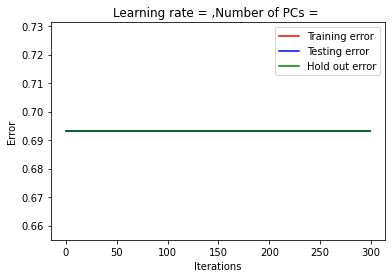

In [212]:
#Plot error/accuracy 
plt.plot(train_error,color = 'red',label = 'Training error')
plt.plot(test_error,color = 'blue',label = 'Testing error')
plt.plot(hold_out_error,color = 'green',label = 'Hold out error')
plt.title("Learning rate = ,Number of PCs = ")
plt.ylabel('Error')
plt.xlabel('Iterations')
plt.legend()
plt.show()

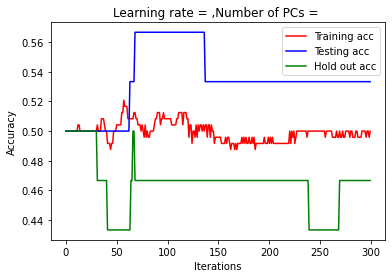

In [213]:
plt.plot(train_acc,color = 'red',label = 'Training acc')
plt.plot(test_acc,color = 'blue',label = 'Testing acc')
plt.plot(hold_out_acc,color = 'green',label = 'Hold out acc')
plt.title("Learning rate = ,Number of PCs = ")
plt.ylabel('Accuracy')
plt.xlabel('Iterations')
plt.legend()
plt.show()